In [2]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [3]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="",
                  password="",
                  host ="redshift.amazonaws.com",
                  port = 5439)

In [4]:
#query
#Filtrar o ano de 2022 apenas para o Gabriel Cardinali
df_tm = '''with objet_1 as (
select tcah.id_agendamento , tcah.datadoatendimento, su.id as id_unidade, su.nome_fantasia, cast(lm.data_hora as time) as hora0, sas.nome_status, lm.status_id,
tcah.nome_especialidade 
from tb_consolidacao_agendamentos_hist tcah 
left join stg_log_marcacoes lm on lm.agendamento_id = tcah.id_agendamento 
left join stg_agendamento_status sas on sas.id = lm.status_id
left join stg_unidades su on su.id = tcah.id_unidade
where 1=1
and tcah.datadoatendimento between '2022-01-01' and '2022-12-31'
and tcah.id_unidade in (19932, 19935, 19728, 19462, 19830, 19855, 19957)
--and tcah.id_agendamento = 809853049 --paravalidar com id do agendamento
),
objet_2 as (
select distinct datadoatendimento, nome_fantasia, id_unidade, nome_especialidade, id_agendamento,
 CASE 
	 WHEN status_id = 204 THEN hora0 END AS "Chamando_pré_consulta", 
	case when status_id = 202 THEN hora0 END AS "Em_atendimento_pré_consulta",
	case when status_id = 33 THEN hora0 END AS "Em_espera",
	case when status_id = 5 THEN hora0 END AS "Chamando",
	case when status_id = 2 THEN hora0 END AS "Em_atendimento",
	case when status_id = 3 THEN hora0 END AS "Atendido",
	case when status_id = 201 THEN hora0 END AS "Aguardando_pós_Consulta",
	case when status_id = 205 THEN hora0 END AS "Chamando_pós_consulta",
	case when status_id = 203 THEN hora0 END AS "Em_atendimento_pós_consulta"	 
from objet_1
where 1=1),
objet_3 as (
select datadoatendimento, nome_fantasia, id_unidade, nome_especialidade, id_agendamento,
	CAST(EXTRACT(HOUR FROM Chamando_pré_consulta) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Chamando_pré_consulta) / 60 AS DECIMAL(10, 2)) AS Chamando_pré_consulta,
	CAST(EXTRACT(HOUR FROM Em_atendimento_pré_consulta) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Em_atendimento_pré_consulta) / 60 AS DECIMAL(10, 2)) AS Em_atendimento_pré_consulta,
	CAST(EXTRACT(HOUR FROM Em_espera) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Em_espera) / 60 AS DECIMAL(10, 2)) AS Em_espera,
	CAST(EXTRACT(HOUR FROM Chamando) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Chamando) / 60 AS DECIMAL(10, 2)) AS Chamando,
	CAST(EXTRACT(HOUR FROM Em_atendimento) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Em_atendimento) / 60 AS DECIMAL(10, 2)) AS Em_atendimento,
	CAST(EXTRACT(HOUR FROM Atendido) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Atendido) / 60 AS DECIMAL(10, 2)) AS Atendido,
	CAST(EXTRACT(HOUR FROM Aguardando_pós_Consulta) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Aguardando_pós_Consulta) / 60 AS DECIMAL(10, 2)) AS Aguardando_pós_Consulta,
	CAST(EXTRACT(HOUR FROM Chamando_pós_consulta) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Chamando_pós_consulta) / 60 AS DECIMAL(10, 2)) AS Chamando_pós_consulta,
	CAST(EXTRACT(HOUR FROM Em_atendimento_pós_consulta) AS DECIMAL(10, 2)) + CAST(EXTRACT(MINUTE FROM Em_atendimento_pós_consulta) / 60 AS DECIMAL(10, 2)) AS Em_atendimento_pós_consulta
FROM objet_2)
select datadoatendimento, nome_fantasia, id_unidade, nome_especialidade, id_agendamento,
	sum(Chamando_pré_consulta) as Chamando_pré_consulta,
	sum(Em_atendimento_pré_consulta) as Em_atendimento_pré_consulta,
	sum(Em_espera) as Em_espera,
	sum(Chamando) as Chamando,
	sum(Em_atendimento) as Em_atendimento,
	sum(Atendido) as Atendido,
	sum(Aguardando_pós_Consulta) as Aguardando_pós_Consulta,
	sum(Chamando_pós_consulta) as Chamando_pós_consulta,
	sum(Em_atendimento_pós_consulta) as Em_atendimento_pós_consulta
from objet_3
group by datadoatendimento, nome_fantasia, nome_especialidade, id_agendamento, id_unidade'''

In [5]:
#df = pd.read_sql_query(df_emails,con=connection)
df_tm = pd.read_sql_query(df_tm,con=connection)

/tmp/ipykernel_966/1537762496.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tm = pd.read_sql_query(df_tm,con=connection)


In [6]:
df_tm1 = df_tm

In [7]:
df_tm2 = df_tm

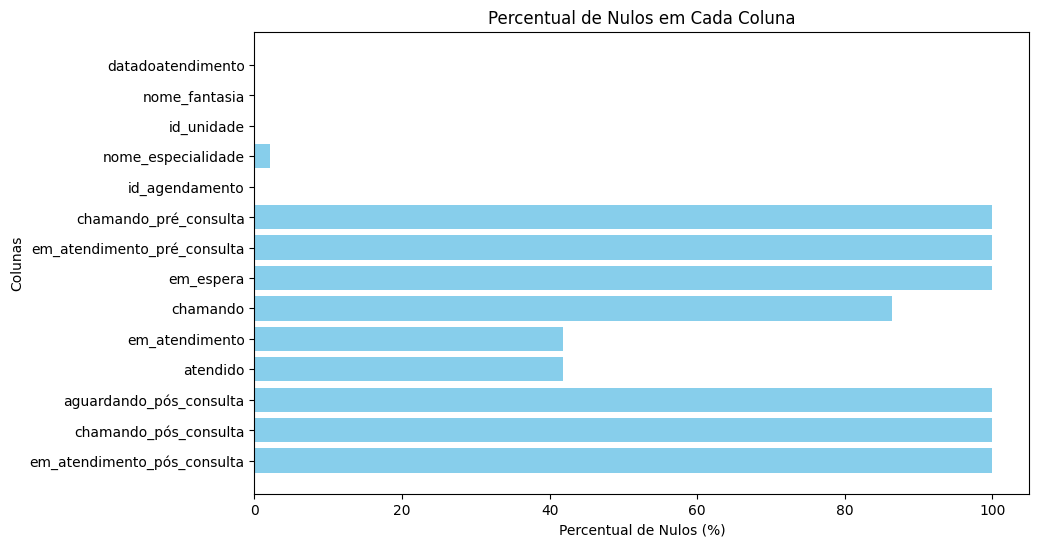

In [8]:
# Contagem de valores nulos em todas as colunas
total_nulos = df_tm.isnull().sum()

# Contagem total de registros no DataFrame
total_registros = len(df_tm)

# Calculando o percentual de nulos em relação ao total
percentual_nulos = (total_nulos / total_registros) * 100

# Crie um DataFrame para exibir os resultados
relatorio_nulos = pd.DataFrame({
    'Total de Nulos': total_nulos,
    'Percentual de Nulos (%)': percentual_nulos
})

# Crie um gráfico de barras para visualizar o percentual de nulos com a cor "skyblue"
plt.figure(figsize=(10, 6))
plt.barh(relatorio_nulos.index, relatorio_nulos['Percentual de Nulos (%)'], color='skyblue')
plt.xlabel('Percentual de Nulos (%)')
plt.ylabel('Colunas')
plt.title('Percentual de Nulos em Cada Coluna')
plt.gca().invert_yaxis()  # Inverte o eixo y para que as colunas mais altas fiquem no topo
plt.show()

In [9]:
#pip install sweetviz
import sweetviz as sv

report = sv.analyze(df_tm)

report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sweetviz/series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()
/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/sweetviz/series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()


Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [10]:
# Crie uma nova DataFrame contendo apenas as colunas 'em_atendimento' e 'atendido'
df_atendimento = df_tm2[['datadoatendimento','nome_fantasia', 'id_unidade','nome_especialidade',	'id_agendamento', 'em_atendimento', 'atendido']]

# Calcule a diferença entre 'atendido' e 'em_atendimento' e crie a coluna 'status_atendimento'
df_atendimento['status_atendimento'] = df_atendimento['atendido'] - df_atendimento['em_atendimento']

/tmp/ipykernel_966/3160851607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atendimento['status_atendimento'] = df_atendimento['atendido'] - df_atendimento['em_atendimento']


In [11]:
df_atendimento = df_atendimento.dropna(subset=['status_atendimento'])

df_atendimento = df_atendimento.loc[df_atendimento['status_atendimento'] >= 0]

# Crie uma nova coluna "status_atendimento_multiplicado" que seja "status_atendimento" multiplicado por 100
df_atendimento['status_atendimento_multiplicado'] = df_atendimento['status_atendimento'] * 100


In [12]:
# Crie um novo DataFrame filtrando os valores maiores que 240 na coluna "status_atendimento_multiplicado"
df_atendimento = df_atendimento[df_atendimento['status_atendimento_multiplicado'] < 300]

Couldn't find a suitable web browser!

Set the BROWSER environment variable to your desired browser.

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: text/html
./usr/bin/xdg-open: 882: x-www-browser: not found


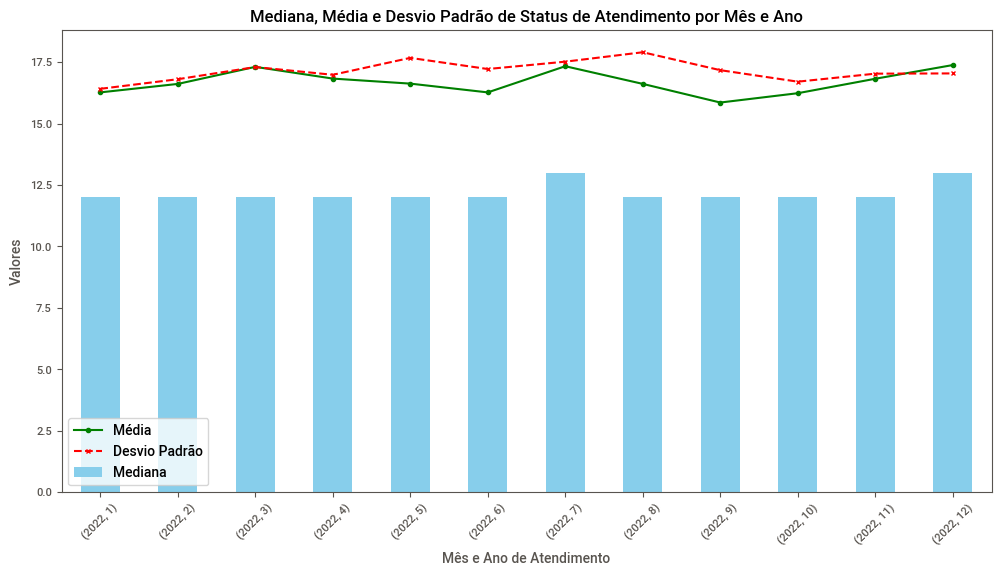

In [13]:
# Converter a coluna "datadoatendimento" para o tipo datetime
df_atendimento['datadoatendimento'] = pd.to_datetime(df_atendimento['datadoatendimento'])

# Criar colunas adicionais para o mês e o ano
df_atendimento['ano'] = df_atendimento['datadoatendimento'].dt.year
df_atendimento['mes'] = df_atendimento['datadoatendimento'].dt.month

# Agrupar o DataFrame por "ano" e "mes" e calcular a mediana, média e desvio padrão de "status_atendimento"
grouped_data = df_atendimento.groupby(['ano', 'mes'])['status_atendimento_multiplicado'].agg(['median', 'mean', 'std'])

# Crie um gráfico de barras para a mediana de "status_atendimento" por mês e ano
plt.figure(figsize=(12, 6))
median_por_data = grouped_data['median']
mean_por_data = grouped_data['mean']
std_por_data = grouped_data['std']

median_por_data.plot(kind='bar', color='skyblue', label='Mediana')
mean_por_data.plot(kind='line', marker='o', color='green', label='Média')
std_por_data.plot(kind='line', linestyle='--', marker='x', color='red', label='Desvio Padrão')

plt.xlabel('Mês e Ano de Atendimento')
plt.ylabel('Valores')
plt.title('Mediana, Média e Desvio Padrão de Status de Atendimento por Mês e Ano')
plt.xticks(rotation=45)
plt.legend()
plt.show()


/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found


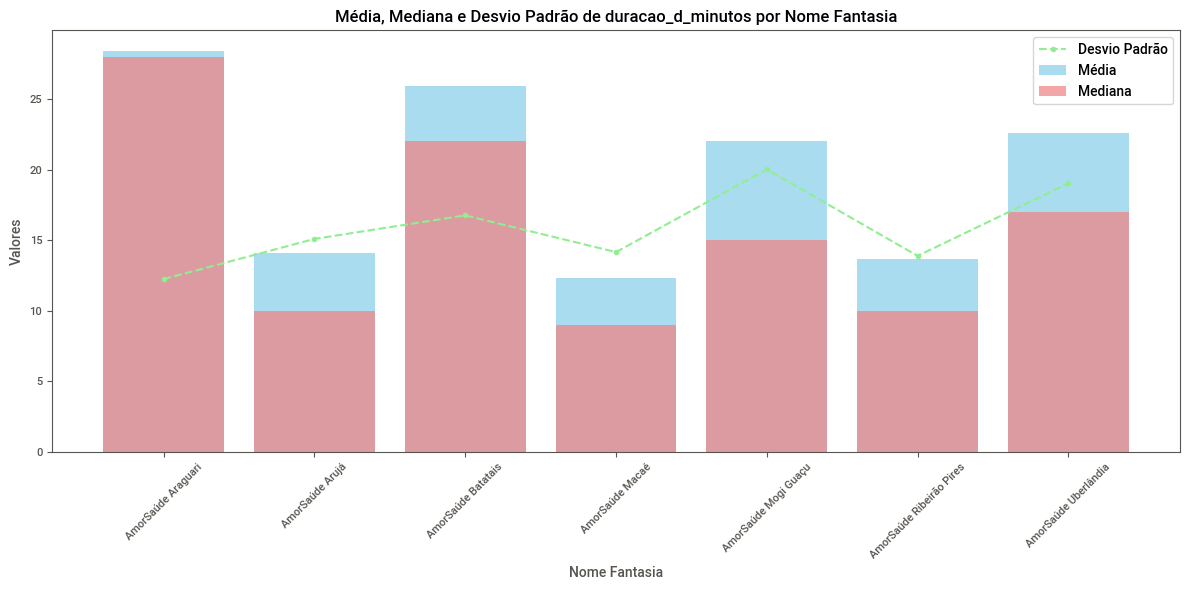

In [14]:
agregacoes = {
    'Média': ('status_atendimento_multiplicado', 'mean'),
    'Mediana': ('status_atendimento_multiplicado', 'median'),
    'Desvio Padrão': ('status_atendimento_multiplicado', 'std')
}

resultado = df_atendimento.groupby('nome_fantasia').agg(**agregacoes).reset_index()

# Criar um gráfico de barras
plt.figure(figsize=(12, 6))
cores = ['skyblue', 'lightcoral']  # Cores para as barras
linhas_cores = 'lightgreen'  # Cor da linha de desvio padrão

# Gráfico de barras
for i, coluna in enumerate(['Média', 'Mediana']):
    plt.bar(
        resultado['nome_fantasia'],
        resultado[coluna],
        label=coluna,
        color=cores[i],
        alpha=0.7,
    )

# Linha de desvio padrão
plt.plot(
    resultado['nome_fantasia'],
    resultado['Desvio Padrão'],
    marker='o',
    linestyle='--',
    color=linhas_cores,
    label='Desvio Padrão',
)

plt.xlabel('Nome Fantasia')
plt.ylabel('Valores')
plt.title('Média, Mediana e Desvio Padrão de duracao_d_minutos por Nome Fantasia')
plt.xticks(rotation=45)

# Adicionar legendas
plt.legend()

plt.tight_layout()
plt.show()

/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found


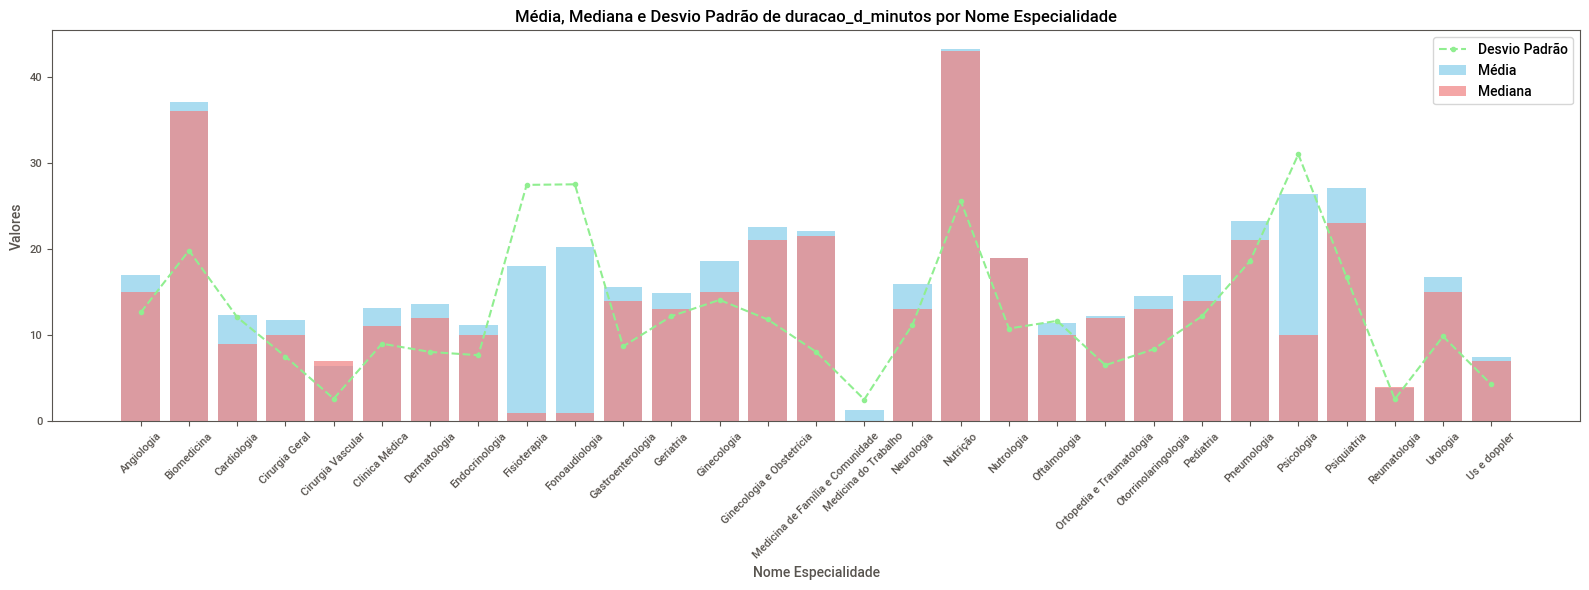

In [15]:

agregacoes = {
    'Média': ('status_atendimento_multiplicado', 'mean'),
    'Mediana': ('status_atendimento_multiplicado', 'median'),
    'Desvio Padrão': ('status_atendimento_multiplicado', 'std')
}

resultado = df_atendimento.groupby('nome_especialidade').agg(**agregacoes).reset_index()

# Criar um gráfico de barras
plt.figure(figsize=(16, 6))
cores = ['skyblue', 'lightcoral']  # Cores para as barras
linhas_cores = 'lightgreen'  # Cor da linha de desvio padrão

# Gráfico de barras
for i, coluna in enumerate(['Média', 'Mediana']):
    plt.bar(
        resultado['nome_especialidade'],
        resultado[coluna],
        label=coluna,
        color=cores[i],
        alpha=0.7,
    )

# Linha de desvio padrão
plt.plot(
    resultado['nome_especialidade'],
    resultado['Desvio Padrão'],
    marker='o',
    linestyle='--',
    color=linhas_cores,
    label='Desvio Padrão',
)

plt.xlabel('Nome Especialidade')
plt.ylabel('Valores')
plt.title('Média, Mediana e Desvio Padrão de duracao_d_minutos por Nome Especialidade')
plt.xticks(rotation=45)

# Adicionar legendas
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Calcula a mediana, média e desvio padrão
median_por_especialidade = df_atendimento.groupby('nome_especialidade')['status_atendimento_multiplicado'].median()
media_por_especialidade = df_atendimento.groupby('nome_especialidade')['status_atendimento_multiplicado'].mean()
desvio_padrao_por_especialidade = df_atendimento.groupby('nome_especialidade')['status_atendimento_multiplicado'].std()

# Crie um DataFrame com esses valores
df_valores = pd.DataFrame({
    'Nome da Especialidade': median_por_especialidade.index,
    'Mediana': median_por_especialidade.values,
    'Média': media_por_especialidade.values,
    'Desvio Padrão': desvio_padrao_por_especialidade.values
})

df_valores

/usr/bin/xdg-open: 882: links2: not found


,Nome da Especialidade,Mediana,Média,Desvio Padrão
0,Angiologia,15.0,17.010717,12.635693
1,Biomedicina,36.0,37.121212,19.820359
2,Cardiologia,9.0,12.285847,12.063470
3,Cirurgia Geral,10.0,11.714286,7.499206
4,Cirurgia Vascular,7.0,6.441176,2.607578
5,Clinica Médica,11.0,13.125348,8.999136
6,Dermatologia,12.0,13.575461,8.037526
7,Endocrinologia,10.0,11.147250,7.658426
8,Fisioterapia,1.0,17.986994,27.443440
9,Fonoaudiologia,1.0,20.231831,27.508538


In [17]:
valor_maximo = 24

faixas = range(0, valor_maximo + 3, 3)  

rotulos = [f'{inicio}-{fim-1}' for inicio, fim in zip(faixas, faixas[1:])]

df_atendimento['faixa_em_atendimento'] = pd.cut(df_atendimento['em_atendimento'], bins=faixas, labels=rotulos)

df_atendimento['faixa_atendido'] = pd.cut(df_atendimento['atendido'], bins=faixas, labels=rotulos)


/usr/bin/xdg-open: 882: elinks: not found


In [18]:
contagem_em_atendimento = df_atendimento.groupby('faixa_em_atendimento').size().reset_index(name='contagem_em_atendimento')

contagem_atendido = df_atendimento.groupby('faixa_atendido').size().reset_index(name='contagem_atendido')

total_atendimentos = contagem_atendido['contagem_atendido'].sum()

/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'file:///home/gabriel/dbt-projects/python_files/analises/notebooks/report.html'


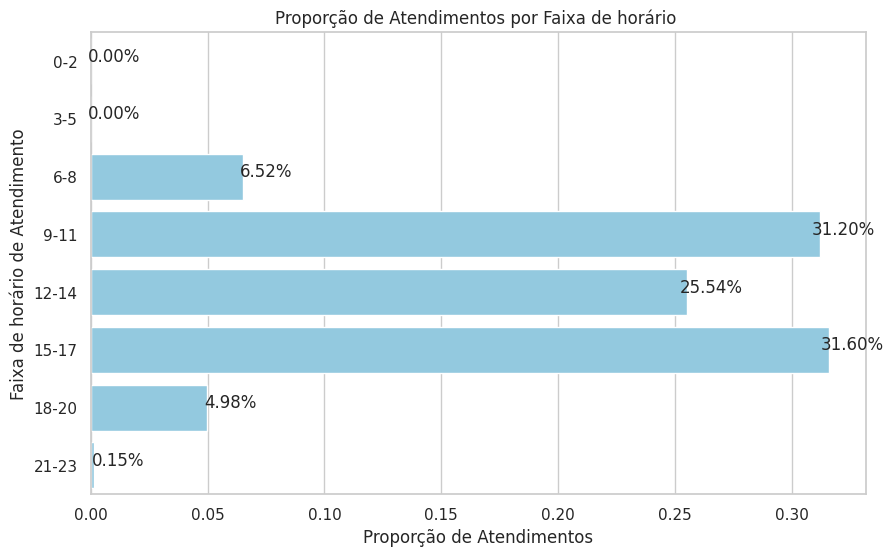

In [19]:
contagem_atendido['proporcao_atendido'] = contagem_atendido['contagem_atendido'] / total_atendimentos

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="proporcao_atendido", y="faixa_atendido", data=contagem_atendido, color="skyblue")

for p in ax.patches:
    ax.annotate(f"{p.get_width():.2%}", (p.get_x() + p.get_width() + 0.01, p.get_y() + p.get_height() / 2), ha='center')


plt.xlabel("Proporção de Atendimentos")
plt.ylabel("Faixa de horário de Atendimento")
plt.title("Proporção de Atendimentos por Faixa de horário ")

plt.show()

In [20]:
df_atendimento

,datadoatendimento,nome_fantasia,id_unidade,nome_especialidade,id_agendamento,em_atendimento,atendido,status_atendimento,status_atendimento_multiplicado,ano,mes,faixa_em_atendimento,faixa_atendido
0,2022-05-19,AmorSaúde Uberlândia,19728,Gastroenterologia,820276561,12.88,13.02,0.14,14.0,2022,5,12-14,12-14
3,2022-05-19,AmorSaúde Macaé,19462,Cardiologia,820618292,18.18,18.27,0.09,9.0,2022,5,18-20,18-20
7,2022-05-25,AmorSaúde Uberlândia,19728,Oftalmologia,820508825,11.80,11.92,0.12,12.0,2022,5,9-11,9-11
9,2022-05-30,AmorSaúde Mogi Guaçu,19830,Oftalmologia,821001556,16.78,16.83,0.05,5.0,2022,5,15-17,15-17
11,2022-05-30,AmorSaúde Macaé,19462,Cardiologia,820630270,19.00,19.02,0.02,2.0,2022,5,18-20,18-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184281,2022-10-17,AmorSaúde Macaé,19462,Clinica Médica,831783784,9.50,9.58,0.08,8.0,2022,10,9-11,9-11
184307,2022-12-15,AmorSaúde Macaé,19462,Cardiologia,836827388,19.33,19.38,0.05,5.0,2022,12,18-20,18-20
184421,2022-10-28,AmorSaúde Macaé,19462,Psicologia,833172497,12.43,12.43,0.00,0.0,2022,10,12-14,12-14
184440,2022-11-08,AmorSaúde Arujá,19855,Cardiologia,833910844,16.08,16.17,0.09,9.0,2022,11,15-17,15-17


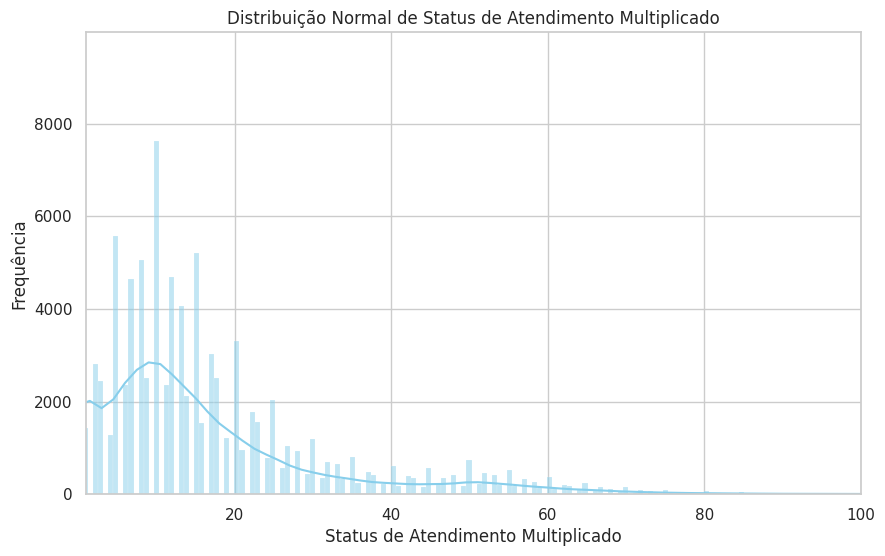

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crie um histograma com a distribuição normal da coluna "status_atendimento_multiplicado"
plt.figure(figsize=(10, 6))
sns.histplot(df_atendimento['status_atendimento_multiplicado'], kde=True, color='skyblue')
plt.xlabel('Status de Atendimento Multiplicado')
plt.ylabel('Frequência')
plt.title('Distribuição Normal de Status de Atendimento Multiplicado')

# Defina os limites do eixo x
plt.xlim(1, 100)  # Substitua 0 e 100 pelos limites desejados

plt.show()


In [22]:

nome_do_arquivo = "esta_especialidade.xlsx"
df_valores.to_excel(nome_do_arquivo, index=False)  

